In [148]:
import torch
import matplotlib.pyplot as plt
from collections import Counter
from ipywidgets import interact, FloatSlider, IntSlider


## let's model the multi armed bandit

In [136]:
class OneArmedBandit():
  def __init__(self):
    self.q_star = torch.normal(mean=torch.tensor(0.0), std = torch.tensor(1.0)) # this represents the action value is given by a distribution with mean 0 and variance 1 --> q*(a), a = 1,..., 10,
  def pull(self):
        # Rt ~ N(q*(a), 1)
        return torch.normal(mean=self.q_star, std = 1.0)
        # when an action is selected (At) at time step t, the actual reward, Rt, is selected from a normal distribution with mean q*(At) and variance 1

class KArmedBandit():
    def __init__(self, k=10, reward_std=1.0):
        self.k = k
        self.q_star = torch.randn(k)          # true means ~ N(0,1) -> initialize each arm-bandit with a q*(a)
        self.reward_std = reward_std

    def pull(self, arm_bandit_index: int) -> torch.Tensor:
        # Rt ~ N(q*(a), 1)
        return self.q_star[arm_bandit_index] + self.reward_std * torch.randn(())


In [137]:
k = 10
k_bandit = KArmedBandit(k)
rewards = [[k_bandit.pull(__) for _ in range(2000)] for __ in range(k)]

In [138]:
greedy_action = torch.argmax(k_bandit.q_star, dim = 0); greedy_action
# choosing the action that has the greatest estimated reward Q at any time step t is called exploiting
# choosing any other action at time t is exploring

tensor(6)

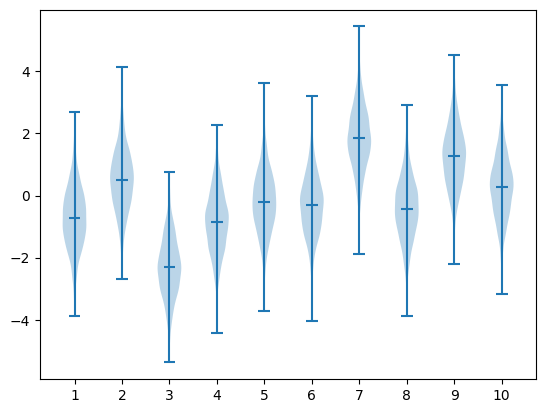

In [147]:
plt.violinplot(rewards,showmeans=True);
plt.xticks(torch.linspace(1,k,k));
# each boxplot represents a the distribution of rewards given by a bandit. the distribution depends on the action value.
# where the action value represents the "true" rewards --> it is defined as the expected value of the rewards given an action a at time step t

# thus what we are doing it:
# - taking one bandit
# - giving to that one bandit a action value (the "true reward") --> extracted from a normal distribution with mean 0 and variance 1
# - pulling the lever of the bandit 2000 times, recording each time the reward,
# - the reward is given by extracting a value from the reward function, that has mean equal to the action value and variance 1

# NB the reward is not always the same, it has a certain volatility, otherwise, the problem would be way simpler. see page 26:
# If you knew the value of each action, then it would be trivial to solve the k-armed bandit problem: you would always select the action with highest value.

## let's model the agent (stationary)

In [217]:
class MetaAgent():
  def __init__(self, k, ε = 0.01):
    self.ε = ε
    self.k = k
    self.Q_estimate = torch.zeros(k) # estimate of the total reward
    self.N_count = torch.zeros(k) # number of times each arm is pulled
    self.rewards = []
    self.log_choice = torch.zeros(2, dtype=torch.int)

  def choose_action(self):
    if torch.rand(()) <=self.ε:
      self.log_choice[0] +=1
      return torch.argmax(torch.rand(self.k)).item() # explore
    else:
      self.log_choice[1] +=1
      return torch.argmax(self.Q_estimate).item() # exploit

  def update(self, reward, action):
        raise NotImplementedError

In [219]:
class EpsilonGreedyAgent(MetaAgent):
  def update(self, reward, action):
    # increment counter for the action
    self.N_count[action] +=1
    # update the estimate for the reward of the action
    self.Q_estimate[action] += (reward-self.Q_estimate[action])*1/self.N_count[action] # for this update see page 31
# we are setting the step size equal to 1/N_count for that specific action

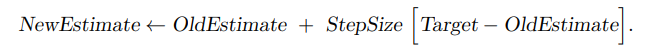

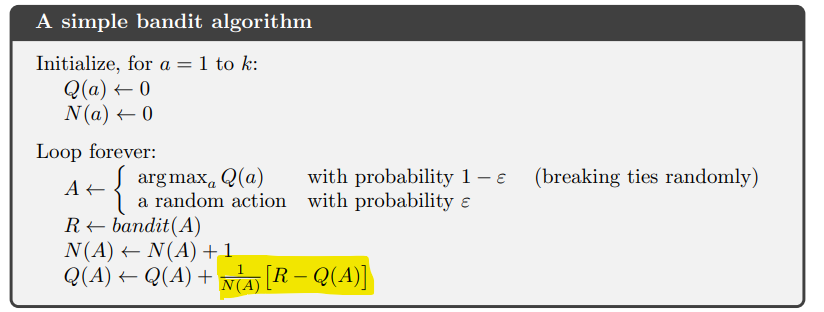

In [220]:
k = 10
k_armed_bandit = KArmedBandit(k)
agent = EpsilonGreedyAgent(k, ε = 0.1)


In [221]:
steps = 1000

for t in range(steps):
    action = agent.choose_action()
    reward = k_armed_bandit.pull(action)
    agent.update(reward, action)
    agent.rewards.append(reward)


<BarContainer object of 2 artists>

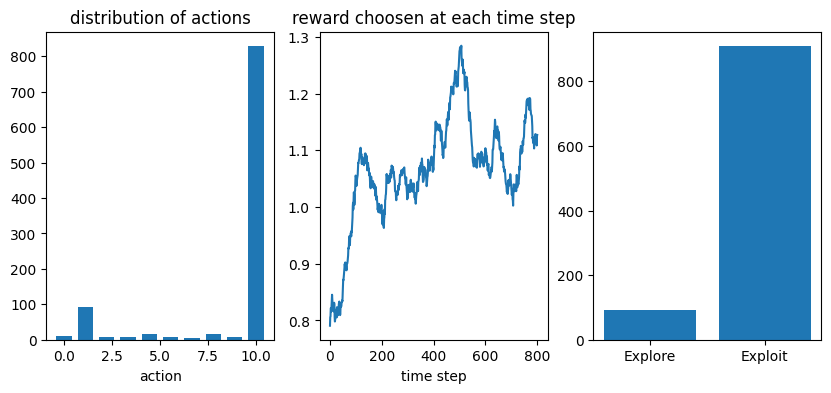

In [222]:
fig, ax = plt.subplots(1,3, figsize = (10,4))

moving_average = torch.nn.AvgPool1d(kernel_size=200, stride = 1)

ax[0].bar(x = torch.linspace(0,k, 10), height = agent.N_count)
ax[0].set_xlabel("action")
ax[0].set_title("distribution of actions")

ax[1].plot(moving_average(torch.tensor(agent.rewards).view(1,1,-1)).squeeze())
ax[1].set_xlabel("time step")
ax[1].set_title("reward choosen at each time step")

ax[2].bar(x = ["Explore", "Exploit"], height = agent.log_choice)

## let's make it cleaner

In [287]:
def simulate(steps:int, k:int, AgentType: MetaAgent, bandit=None, **kwargs)->MetaAgent:
    if bandit is None:
        bandit = KArmedBandit(k)
    agent = AgentType(k, **kwargs)
    for t in range(steps):
        action = agent.choose_action()
        reward = bandit.pull(action)
        agent.update(reward, action)
        agent.rewards.append(reward)
    return agent


In [288]:
moving_average = torch.nn.AvgPool1d(kernel_size=2, stride = 2) # how many to skip after calculating the first one [1,2,3,4,5] --> kernel = 2 --> stride = 1 --> takes
moving_average(torch.tensor([1,2,3,4,5,6], dtype = torch.float32).view(1,1,-1))

tensor([[[1.5000, 3.5000, 5.5000]]])

In [289]:
# usage
k = 10
steps = 1000
ε = 0.1

agent = simulate(steps,k,EpsilonGreedyAgent,ε = ε  )
len(agent.rewards)

1000

In [290]:
def viz(window, stride,  ε):
  agent = simulate(steps, k, EpsilonGreedyAgent, ε = ε)
  fig, ax = plt.subplots(1,3, figsize = (10,4))

  moving_average = torch.nn.AvgPool1d(kernel_size=window, stride = stride)

  ax[0].bar(x = torch.linspace(0,k, 10), height = agent.N_count)
  ax[0].set_xlabel("action")
  ax[0].set_title("distribution of actions")

  ax[1].plot(moving_average(torch.tensor(agent.rewards).view(1,1,-1)).squeeze())
  ax[1].set_xlabel("time step")
  ax[1].set_title("reward choosen at each time step")

  ax[2].bar(x = ["Explore", "Exploit"], height = agent.log_choice)


In [292]:
interact(
    viz,
    window=IntSlider(value=100, min=1, max=200, step=10, description="window"),
    stride=IntSlider(value=10, min=1, max=200, step=10, description="stride"),
    ε=FloatSlider(value=0.01, min=0.01, max=1.0, step=0.01, description="ε"),
);


interactive(children=(IntSlider(value=100, description='window', max=200, min=1, step=10), IntSlider(value=10,…

## an agent with constant step size (non-stationary)

In [293]:
class EpsilonGreedyAgentConst(MetaAgent):
  def __init__(self, k, ε=0.01, α=0.1):
        super().__init__(k, ε)
        self.α = α
  def update(self, reward, action):
    # increment counter for the action
    self.N_count[action] +=1
    # update the estimate for the reward of the action
    self.Q_estimate[action] += (reward-self.Q_estimate[action])*self.α # for this update see page 31
# constant step size α, good for nonstationary problems


In [294]:
k = 10
steps = 1000

agents = []
alphas = [0.1,0.3, 0.4]

for α in alphas:
    agent = simulate(steps,k,EpsilonGreedyAgentConst,α = α )
    agents.append(agent)
len(agents[0].rewards)

1000

In [295]:
def viz(window, stride,  ε, α ):
  agent = simulate(steps, k, EpsilonGreedyAgentConst, ε = ε, α =α)
  fig, ax = plt.subplots(1,3, figsize = (10,4))

  moving_average = torch.nn.AvgPool1d(kernel_size=200, stride = 1)

  ax[0].bar(x = torch.linspace(0,k, 10), height = agent.N_count)
  ax[0].set_xlabel("action")
  ax[0].set_title("distribution of actions")

  ax[1].plot(moving_average(torch.tensor(agent.rewards).view(1,1,-1)).squeeze())
  ax[1].set_xlabel("time step")
  ax[1].set_title("reward choosen at each time step")

  ax[2].bar(x = ["Explore", "Exploit"], height = agent.log_choice)



interact(
    viz,
    window=IntSlider(value=100, min=1, max=200, step=10, description="window"),
    stride=IntSlider(value=100, min=1, max=200, step=10, description="stride"),
    ε=FloatSlider(value=0.01, min=0.01, max=1.0, step=0.01, description="ε"),
    α = FloatSlider(value=0.01, min=0., max=1.0, step=0.01, description="alpha")
);


interactive(children=(IntSlider(value=100, description='window', max=200, min=1, step=10), IntSlider(value=100…

## optimistic values

In [296]:
# At the start, all Q_estimate[a] are initialized higher than the true action values q∗(a).
class EpsilonGreedyAgentOpt(MetaAgent):

  def __init__(self, k, ε=0.01, optimistic_initial_value=0):
        super().__init__(k, ε)
        self.α = α
        self.Q_estimate = torch.zeros(k) + optimistic_initial_value

  def update(self, reward, action):
        self.N_count[action] += 1
        α = 1.0 / self.N_count[action]
        self.Q_estimate[action] += α * (reward - self.Q_estimate[action])


In [298]:
fixed_bandit = KArmedBandit(k)

def viz(window, stride,  ε, optimistic_initial_value):
  agent = simulate(steps, k, EpsilonGreedyAgentOpt, ε = ε, optimistic_initial_value=optimistic_initial_value,bandit = fixed_bandit)
  fig, ax = plt.subplots(1,3, figsize = (10,4))

  moving_average = torch.nn.AvgPool1d(kernel_size=200, stride = 1)

  ax[0].bar(x = torch.linspace(0,k, 10), height = agent.N_count)
  ax[0].set_xlabel("action")
  ax[0].set_title("distribution of actions")

  ax[1].plot(moving_average(torch.tensor(agent.rewards).view(1,1,-1)).squeeze())
  ax[1].set_xlabel("time step")
  ax[1].set_title("reward choosen at each time step")

  ax[2].bar(x = ["Explore", "Exploit"], height = agent.log_choice)



interact(
    viz,
    window=IntSlider(value=100, min=1, max=200, step=10, description="window"),
    stride=IntSlider(value=100, min=1, max=200, step=10, description="stride"),
    ε=FloatSlider(value=0.01, min=0.0, max=1.0, step=0.01, description="ε"),
    optimistic_initial_value = FloatSlider(value=0.0, min=0., max=10.0, step=0.01, description="optimistic_initial_value")
);


interactive(children=(IntSlider(value=100, description='window', max=200, min=1, step=10), IntSlider(value=100…